***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- **(Mod-2.7)** From coarse-to-Fine slowly decrease the dimension. i.e. 32D>24D>16D (Coarse>Medium>FINE), While keeping the primary capsule dimension same as original ($P_{capsule} = 8D$). Training with $L_{cons}$
    

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\HD-CapsNet_MOD\Training_and_Analysis\4_CIFAR-100
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "2" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  2
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


## log directory

In [4]:
directory = sysenv.log_dir('4_CIFAR_100/HD_CapsNet/Mod_2_7')

FOLDER CREATED =  ../../logs/4_CIFAR_100/HD_CapsNet/Mod_2_7


# Import Dataset : CIFAR-100

In [5]:
dataset = datasets.CIFAR100(version = 'ALL') # importing CIFAR10 Dataset
# dataset = datasets.CIFAR100(version = 'reduce') # importing CIFAR10 Dataset


CIFAR-100 dataset: Training have 50,000 samples and testing have 10,000 samples


# Parameters

In [6]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

## Learning Rate Decay Scheduler

In [7]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Bottom up Approach

## Loss Function

In [8]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_m = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "medium": number_of_classes_m,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [9]:
coarse_to_medium_array = np.zeros(shape=[number_of_classes_c,number_of_classes_m], dtype=np.int32)
medium_to_fine_array = np.zeros(shape=[number_of_classes_m,number_of_classes_f], dtype=np.int32)

c_id = np.argmax(dataset['y_train_coarse'],1)

m_id = np.argmax(dataset['y_train_medium'],1)

f_id = np.argmax(dataset['y_train_fine'],1)

for x in range(len(dataset['y_test_medium'])):
    coarse_to_medium_array[c_id[x]][m_id[x]] = 1
    
for x in range(len(dataset['y_test_fine'])):
    medium_to_fine_array[m_id[x]][f_id[x]] = 1

Matrix_coarse_to_medium_OneHot = tf.constant(coarse_to_medium_array, dtype=tf.float32)
Matrix_medium_to_fine_OneHot = tf.constant(medium_to_fine_array, dtype=tf.float32)

In [10]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")

    return total_marginloss


def consistency_check(y_pred_ancestor,y_pred_current,lookup_matrix,num_class_current):
    pred_max_ancestor = tf.argmax(y_pred_ancestor,axis=1)
    pred_max_current = tf.argmax(y_pred_current,axis=1)
    
    consistant_check = tf.gather(lookup_matrix, indices=pred_max_ancestor)*tf.one_hot(pred_max_current,num_class_current)
    
    return tf.reduce_sum(consistant_check,1)

def get_consistency(y_true_ancestor, y_pred, lookup_matrix):
    '''
    Get consistency based on 2 levels
    Provide ture levels for the level above, predictions for the current level and a look up metrix
    '''
    y_prob = tf.math.divide(y_pred,tf.reshape(tf.reduce_sum(y_pred,-1),(-1,1),name='reshape'),name='Probability')
    
    index_for_predictions = tf.cast(tf.math.argmax(y_true_ancestor,axis=1),dtype= 'int32')
    consistent_fine = tf.gather(lookup_matrix, indices=index_for_predictions) * y_prob
    Consistency_sum_array = tf.reduce_sum(consistent_fine, axis =1)
    
    return tf.abs(1-Consistency_sum_array)

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F,tree: Tree,C_Weight=0.2):
    
    con_m = consistency_check(y_pred_c,y_pred_m,Matrix_coarse_to_medium_OneHot,num_class_current=number_of_classes_m)
    con_m_not = tf.abs(con_m-1)
    
    con_f = consistency_check(y_pred_m,y_pred_f,Matrix_medium_to_fine_OneHot,num_class_current=number_of_classes_f)
    con_f_not = tf.abs(con_f-1)
    
    con_sum_m = get_consistency(y_true_c,y_pred_m,Matrix_coarse_to_medium_OneHot)
    con_sum_f = get_consistency(y_true_m,y_pred_f,Matrix_medium_to_fine_OneHot)
    
    medium_lvl_cosistency = con_sum_m * con_m_not
    fine_lvl_cosistency = con_sum_f * con_f_not    
   
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*((1-C_Weight)*(margin_loss(y_true_m, y_pred_m))+C_Weight*(medium_lvl_cosistency))
    ML_f = LW_F*((1-C_Weight)*(margin_loss(y_true_f, y_pred_f))+C_Weight*(fine_lvl_cosistency))
    
    batch_loss = ML_c + ML_m+ ML_f

    return tf.reduce_mean(batch_loss)

## Model Architecture

In [11]:
def get_compiled_model():
    input_shape = dataset['x_train'].shape[1:]

    input_shape_yc = dataset['y_train_coarse'].shape[1:]
    input_shape_ym = dataset['y_train_medium'].shape[1:]
    input_shape_yf = dataset['y_train_fine'].shape[1:]

    no_coarse_class = number_of_classes_c
    no_medium_class = number_of_classes_m
    no_fine_class = number_of_classes_f

    PCap_n_dims = 8

    SCap_f_dims = 16
    SCap_m_dims = 24
    SCap_c_dims = 32


    # Input image
    x_input = keras.layers.Input(shape=input_shape, name="Input_Image")

    # Input True Labels
    y_c = keras.layers.Input(shape=input_shape_yc, name='input_yc')
    y_m = keras.layers.Input(shape=input_shape_ym, name='input_ym')
    y_f = keras.layers.Input(shape=input_shape_yf, name='input_yf')

    #--- block 1 ---
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #--- block 2 ---
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #--- block 3 ---
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    #--- block 4 ---
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


    # Layer 3: Reshape to 8D primary capsules 
    reshapec = keras.layers.Reshape((int((tf.reduce_prod(x.shape[1:]).numpy())/PCap_n_dims),
                                     PCap_n_dims), name="reshape_layer")(x)
    p_caps = keras.layers.Lambda(models.squash, name='p_caps')(reshapec)

    ## Layer Secondary Capsule: For coarse level
    s_caps_c = models.SecondaryCapsule(n_caps=no_coarse_class, n_dims=SCap_c_dims, 
                        name="s_caps_coarse")(p_caps)
    
    ## Layer Secondary Capsule: For medium level
    s_caps_m = models.SecondaryCapsule(n_caps=no_medium_class, n_dims=SCap_m_dims, 
                        name="s_caps_medium")(s_caps_c)

    ## Layer Secondary Capsule: For fine level
    s_caps_f = models.SecondaryCapsule(n_caps=no_fine_class, n_dims=SCap_f_dims, 
                        name="s_caps_fine")(s_caps_m)

    pred_c = models.LengthLayer(name='prediction_coarse')(s_caps_c)

    pred_m = models.LengthLayer(name='prediction_medium')(s_caps_m)

    pred_f = models.LengthLayer(name='prediction_fine')(s_caps_f)

    model = keras.Model(inputs= [x_input, y_c, y_m, y_f],
                        outputs= [pred_c, pred_m, pred_f],
                        name='HD-CapsNet')

    model.add_loss(CustomLoss(y_c, y_m, y_f, pred_c, pred_m, pred_f, 
                              lossweight['coarse_lw'], lossweight['medium_lw'], lossweight['fine_lw'],
                              dataset['tree']))

    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'
                          }
    )
    return model

In [12]:
model = get_compiled_model()

In [13]:
model.summary()
# keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 32, 32, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 32, 32, 64)   36928       ['batch_normalization[0]

                                                                                                  
 tf.cast (TFOpLambda)           (None,)              0           ['tf.math.argmax_4[0][0]']       
                                                                                                  
 tf.reshape (TFOpLambda)        (None, 1)            0           ['tf.math.reduce_sum_2[0][0]']   
                                                                                                  
 tf.math.argmax (TFOpLambda)    (None,)              0           ['prediction_coarse[0][0]']      
                                                                                                  
 tf.math.argmax_1 (TFOpLambda)  (None,)              0           ['prediction_medium[0][0]']      
                                                                                                  
 tf.math.argmax_5 (TFOpLambda)  (None,)              0           ['input_ym[0][0]']               
          

 da)                                                                                              
                                                                                                  
 tf.math.reduce_sum (TFOpLambda  (None,)             0           ['tf.math.multiply[0][0]']       
 )                                                                                                
                                                                                                  
 tf.math.maximum_4 (TFOpLambda)  (None, 100)         0           ['tf.math.subtract_10[0][0]']    
                                                                                                  
 tf.math.subtract_12 (TFOpLambd  (None, 100)         0           ['input_yf[0][0]']               
 a)                                                                                               
                                                                                                  
 tf.math.m

                                                                                                  
 tf.math.multiply_4 (TFOpLambda  (None,)             0           ['tf.math.abs_2[0][0]',          
 )                                                                'tf.math.abs[0][0]']            
                                                                                                  
 tf.math.add_2 (TFOpLambda)     (None, 100)          0           ['tf.math.multiply_16[0][0]',    
                                                                  'tf.math.multiply_18[0][0]']    
                                                                                                  
 tf.math.abs_3 (TFOpLambda)     (None,)              0           ['tf.math.subtract_3[0][0]']     
                                                                                                  
 tf.math.abs_1 (TFOpLambda)     (None,)              0           ['tf.math.subtract_1[0][0]']     
          

## Data Augmentation

In [14]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_add_loss.MixupGenerator_3level(dataset['x_train'],
                                                 dataset['y_train_coarse'], 
                                                 dataset['y_train_medium'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [15]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/epoch-best.h5', 
    monitor='val_prediction_fine_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = models.LossWeightsModifier(lossweight = lossweight,
                               initial_lw = initial_lw,
                               directory = directory)
lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [16]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    
    model.save_weights(model_save_dir)

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 0.5064 - prediction_coarse_accuracy: 0.4656 - prediction_medium_accuracy: 0.1979 - prediction_fine_accuracy: 0.0133
  • Coarse Accuracy = 46.56% | Val_Accuracy = 54.43% | LossWeight = 0.36 
  • Medium Accuracy = 19.79% | Val_Accuracy = 29.81% | LossWeight = 0.49 
  • Fine   Accuracy = 1.33% | Val_Accuracy = 2.89% | LossWeight = 0.15 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.02890, saving model to ../../logs/4_CIFAR_100/HD_CapsNet/Mod_2_7\epoch-best.h5
781/781 [==============================] - 68s 77ms/step - loss: 0.5064 - prediction_coarse_accuracy: 0.4656 - prediction_medium_accuracy: 0.1979 - prediction_fine_accuracy: 0.0133 - val_loss: 0.4129 - val_prediction_coarse_accuracy: 0.5443 - val_prediction_medium_accuracy: 0.2981 - val_prediction_fine_accuracy: 0.0289 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.3563 - prediction_coarse_accuracy: 0.5893 - 

781/781 [==============================] - ETA: 0s - loss: 0.1957 - prediction_coarse_accuracy: 0.8241 - prediction_medium_accuracy: 0.7188 - prediction_fine_accuracy: 0.2156
  • Coarse Accuracy = 82.41% | Val_Accuracy = 80.43% | LossWeight = 0.29 
  • Medium Accuracy = 71.88% | Val_Accuracy = 68.34% | LossWeight = 0.41 
  • Fine   Accuracy = 21.56% | Val_Accuracy = 21.63% | LossWeight = 0.30 

Epoch 9: val_prediction_fine_accuracy improved from 0.19570 to 0.21630, saving model to ../../logs/4_CIFAR_100/HD_CapsNet/Mod_2_7\epoch-best.h5
781/781 [==============================] - 59s 76ms/step - loss: 0.1957 - prediction_coarse_accuracy: 0.8241 - prediction_medium_accuracy: 0.7188 - prediction_fine_accuracy: 0.2156 - val_loss: 0.1764 - val_prediction_coarse_accuracy: 0.8043 - val_prediction_medium_accuracy: 0.6834 - val_prediction_fine_accuracy: 0.2163 - lr: 0.0010
Epoch 10/100
781/781 [==============================] - ETA: 0s - loss: 0.1870 - prediction_coarse_accuracy: 0.8340 - predic

Epoch 18/100
781/781 [==============================] - ETA: 0s - loss: 0.1305 - prediction_coarse_accuracy: 0.9131 - prediction_medium_accuracy: 0.8678 - prediction_fine_accuracy: 0.3639
  • Coarse Accuracy = 91.31% | Val_Accuracy = 83.37% | LossWeight = 0.25 
  • Medium Accuracy = 86.78% | Val_Accuracy = 72.96% | LossWeight = 0.34 
  • Fine   Accuracy = 36.39% | Val_Accuracy = 31.84% | LossWeight = 0.42 

Epoch 18: val_prediction_fine_accuracy did not improve from 0.32100
781/781 [==============================] - 59s 76ms/step - loss: 0.1305 - prediction_coarse_accuracy: 0.9131 - prediction_medium_accuracy: 0.8678 - prediction_fine_accuracy: 0.3639 - val_loss: 0.1473 - val_prediction_coarse_accuracy: 0.8337 - val_prediction_medium_accuracy: 0.7296 - val_prediction_fine_accuracy: 0.3184 - lr: 6.6342e-04
Epoch 19/100
781/781 [==============================] - ETA: 0s - loss: 0.1273 - prediction_coarse_accuracy: 0.9151 - prediction_medium_accuracy: 0.8725 - prediction_fine_accuracy: 0.

Epoch 27/100
781/781 [==============================] - ETA: 0s - loss: 0.1072 - prediction_coarse_accuracy: 0.9369 - prediction_medium_accuracy: 0.9129 - prediction_fine_accuracy: 0.5158
  • Coarse Accuracy = 93.69% | Val_Accuracy = 84.46% | LossWeight = 0.25 
  • Medium Accuracy = 91.29% | Val_Accuracy = 74.79% | LossWeight = 0.31 
  • Fine   Accuracy = 51.58% | Val_Accuracy = 44.56% | LossWeight = 0.44 

Epoch 27: val_prediction_fine_accuracy improved from 0.43830 to 0.44560, saving model to ../../logs/4_CIFAR_100/HD_CapsNet/Mod_2_7\epoch-best.h5
781/781 [==============================] - 59s 76ms/step - loss: 0.1072 - prediction_coarse_accuracy: 0.9369 - prediction_medium_accuracy: 0.9129 - prediction_fine_accuracy: 0.5158 - val_loss: 0.1336 - val_prediction_coarse_accuracy: 0.8446 - val_prediction_medium_accuracy: 0.7479 - val_prediction_fine_accuracy: 0.4456 - lr: 4.1812e-04
Epoch 28/100
781/781 [==============================] - ETA: 0s - loss: 0.1073 - prediction_coarse_accurac

Epoch 36/100
781/781 [==============================] - ETA: 0s - loss: 0.0972 - prediction_coarse_accuracy: 0.9485 - prediction_medium_accuracy: 0.9324 - prediction_fine_accuracy: 0.6025
  • Coarse Accuracy = 94.85% | Val_Accuracy = 84.39% | LossWeight = 0.25 
  • Medium Accuracy = 93.24% | Val_Accuracy = 74.72% | LossWeight = 0.30 
  • Fine   Accuracy = 60.25% | Val_Accuracy = 49.00% | LossWeight = 0.45 

Epoch 36: val_prediction_fine_accuracy did not improve from 0.49960
781/781 [==============================] - 59s 76ms/step - loss: 0.0972 - prediction_coarse_accuracy: 0.9485 - prediction_medium_accuracy: 0.9324 - prediction_fine_accuracy: 0.6025 - val_loss: 0.1335 - val_prediction_coarse_accuracy: 0.8439 - val_prediction_medium_accuracy: 0.7472 - val_prediction_fine_accuracy: 0.4900 - lr: 2.6352e-04
Epoch 37/100
781/781 [==============================] - ETA: 0s - loss: 0.0982 - prediction_coarse_accuracy: 0.9480 - prediction_medium_accuracy: 0.9314 - prediction_fine_accuracy: 0.

781/781 [==============================] - ETA: 0s - loss: 0.0943 - prediction_coarse_accuracy: 0.9529 - prediction_medium_accuracy: 0.9386 - prediction_fine_accuracy: 0.6552
  • Coarse Accuracy = 95.29% | Val_Accuracy = 85.25% | LossWeight = 0.26 
  • Medium Accuracy = 93.86% | Val_Accuracy = 76.11% | LossWeight = 0.30 
  • Fine   Accuracy = 65.52% | Val_Accuracy = 52.71% | LossWeight = 0.44 

Epoch 45: val_prediction_fine_accuracy improved from 0.52530 to 0.52710, saving model to ../../logs/4_CIFAR_100/HD_CapsNet/Mod_2_7\epoch-best.h5
781/781 [==============================] - 59s 76ms/step - loss: 0.0943 - prediction_coarse_accuracy: 0.9529 - prediction_medium_accuracy: 0.9386 - prediction_fine_accuracy: 0.6552 - val_loss: 0.1275 - val_prediction_coarse_accuracy: 0.8525 - val_prediction_medium_accuracy: 0.7611 - val_prediction_fine_accuracy: 0.5271 - lr: 1.6608e-04
Epoch 46/100
781/781 [==============================] - ETA: 0s - loss: 0.0929 - prediction_coarse_accuracy: 0.9536 - p

781/781 [==============================] - ETA: 0s - loss: 0.0905 - prediction_coarse_accuracy: 0.9542 - prediction_medium_accuracy: 0.9416 - prediction_fine_accuracy: 0.6873
  • Coarse Accuracy = 95.42% | Val_Accuracy = 85.51% | LossWeight = 0.27 
  • Medium Accuracy = 94.16% | Val_Accuracy = 76.52% | LossWeight = 0.31 
  • Fine   Accuracy = 68.73% | Val_Accuracy = 54.13% | LossWeight = 0.43 

Epoch 54: val_prediction_fine_accuracy improved from 0.54090 to 0.54130, saving model to ../../logs/4_CIFAR_100/HD_CapsNet/Mod_2_7\epoch-best.h5
781/781 [==============================] - 59s 76ms/step - loss: 0.0905 - prediction_coarse_accuracy: 0.9542 - prediction_medium_accuracy: 0.9416 - prediction_fine_accuracy: 0.6873 - val_loss: 0.1263 - val_prediction_coarse_accuracy: 0.8551 - val_prediction_medium_accuracy: 0.7652 - val_prediction_fine_accuracy: 0.5413 - lr: 1.0467e-04
Epoch 55/100
781/781 [==============================] - ETA: 0s - loss: 0.0904 - prediction_coarse_accuracy: 0.9551 - p

781/781 [==============================] - ETA: 0s - loss: 0.0893 - prediction_coarse_accuracy: 0.9560 - prediction_medium_accuracy: 0.9433 - prediction_fine_accuracy: 0.7072
  • Coarse Accuracy = 95.60% | Val_Accuracy = 85.63% | LossWeight = 0.27 
  • Medium Accuracy = 94.33% | Val_Accuracy = 76.62% | LossWeight = 0.31 
  • Fine   Accuracy = 70.72% | Val_Accuracy = 55.25% | LossWeight = 0.42 

Epoch 63: val_prediction_fine_accuracy improved from 0.55120 to 0.55250, saving model to ../../logs/4_CIFAR_100/HD_CapsNet/Mod_2_7\epoch-best.h5
781/781 [==============================] - 60s 77ms/step - loss: 0.0893 - prediction_coarse_accuracy: 0.9560 - prediction_medium_accuracy: 0.9433 - prediction_fine_accuracy: 0.7072 - val_loss: 0.1254 - val_prediction_coarse_accuracy: 0.8563 - val_prediction_medium_accuracy: 0.7662 - val_prediction_fine_accuracy: 0.5525 - lr: 6.5971e-05
Epoch 64/100
781/781 [==============================] - ETA: 0s - loss: 0.0897 - prediction_coarse_accuracy: 0.9568 - p

781/781 [==============================] - 60s 77ms/step - loss: 0.0885 - prediction_coarse_accuracy: 0.9568 - prediction_medium_accuracy: 0.9448 - prediction_fine_accuracy: 0.7227 - val_loss: 0.1249 - val_prediction_coarse_accuracy: 0.8567 - val_prediction_medium_accuracy: 0.7698 - val_prediction_fine_accuracy: 0.5561 - lr: 4.1578e-05
Epoch 73/100
781/781 [==============================] - ETA: 0s - loss: 0.0881 - prediction_coarse_accuracy: 0.9578 - prediction_medium_accuracy: 0.9457 - prediction_fine_accuracy: 0.7263
  • Coarse Accuracy = 95.78% | Val_Accuracy = 85.81% | LossWeight = 0.27 
  • Medium Accuracy = 94.57% | Val_Accuracy = 77.00% | LossWeight = 0.32 
  • Fine   Accuracy = 72.63% | Val_Accuracy = 55.78% | LossWeight = 0.41 

Epoch 73: val_prediction_fine_accuracy improved from 0.55700 to 0.55780, saving model to ../../logs/4_CIFAR_100/HD_CapsNet/Mod_2_7\epoch-best.h5
781/781 [==============================] - 60s 77ms/step - loss: 0.0881 - prediction_coarse_accuracy: 0.95

Epoch 82/100
781/781 [==============================] - ETA: 0s - loss: 0.0879 - prediction_coarse_accuracy: 0.9574 - prediction_medium_accuracy: 0.9458 - prediction_fine_accuracy: 0.7317
  • Coarse Accuracy = 95.74% | Val_Accuracy = 86.03% | LossWeight = 0.28 
  • Medium Accuracy = 94.58% | Val_Accuracy = 76.81% | LossWeight = 0.32 
  • Fine   Accuracy = 73.17% | Val_Accuracy = 55.70% | LossWeight = 0.41 

Epoch 82: val_prediction_fine_accuracy did not improve from 0.55840
781/781 [==============================] - 60s 77ms/step - loss: 0.0879 - prediction_coarse_accuracy: 0.9574 - prediction_medium_accuracy: 0.9458 - prediction_fine_accuracy: 0.7317 - val_loss: 0.1239 - val_prediction_coarse_accuracy: 0.8603 - val_prediction_medium_accuracy: 0.7681 - val_prediction_fine_accuracy: 0.5570 - lr: 2.4894e-05
Epoch 83/100
781/781 [==============================] - ETA: 0s - loss: 0.0878 - prediction_coarse_accuracy: 0.9576 - prediction_medium_accuracy: 0.9459 - prediction_fine_accuracy: 0.

781/781 [==============================] - 60s 77ms/step - loss: 0.0874 - prediction_coarse_accuracy: 0.9586 - prediction_medium_accuracy: 0.9469 - prediction_fine_accuracy: 0.7374 - val_loss: 0.1240 - val_prediction_coarse_accuracy: 0.8593 - val_prediction_medium_accuracy: 0.7721 - val_prediction_fine_accuracy: 0.5602 - lr: 1.5690e-05
Epoch 92/100
781/781 [==============================] - ETA: 0s - loss: 0.0878 - prediction_coarse_accuracy: 0.9569 - prediction_medium_accuracy: 0.9453 - prediction_fine_accuracy: 0.7355
  • Coarse Accuracy = 95.69% | Val_Accuracy = 85.98% | LossWeight = 0.28 
  • Medium Accuracy = 94.53% | Val_Accuracy = 77.22% | LossWeight = 0.32 
  • Fine   Accuracy = 73.55% | Val_Accuracy = 55.98% | LossWeight = 0.40 

Epoch 92: val_prediction_fine_accuracy did not improve from 0.56080
781/781 [==============================] - 60s 77ms/step - loss: 0.0878 - prediction_coarse_accuracy: 0.9569 - prediction_medium_accuracy: 0.9453 - prediction_fine_accuracy: 0.7355 - 

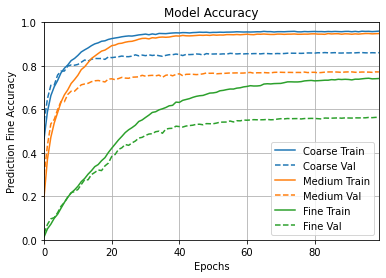

In [17]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

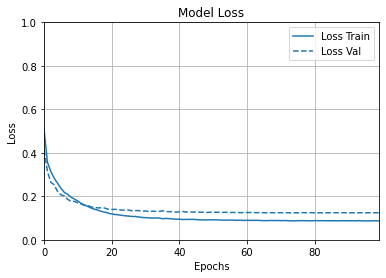

In [18]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

## Model Analysis

In [19]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 8s 20ms/step - loss: 0.2327 - prediction_coarse_loss: 0.1058 - prediction_medium_loss: 0.1750 - prediction_fine_loss: 0.3619 - prediction_coarse_accuracy: 0.8606 - prediction_medium_accuracy: 0.7721 - prediction_fine_accuracy: 0.5632
1. loss ==> 0.2327403873205185
2. prediction_coarse_loss ==> 0.10583002865314484
3. prediction_medium_loss ==> 0.17496374249458313
4. prediction_fine_loss ==> 0.36194634437561035
5. prediction_coarse_accuracy ==> 0.8605999946594238
6. prediction_medium_accuracy ==> 0.7720999717712402
7. prediction_fine_accuracy ==> 0.5631999969482422
313/313 [==============================] - 5s 14ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

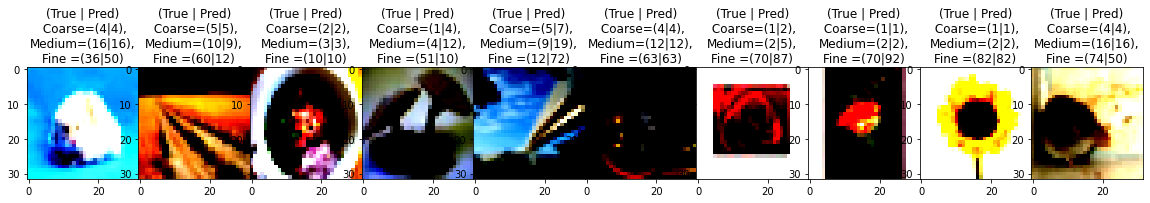

In [20]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[ 717   10   21   31  183   16    9   13]
 [   9 1362   28   26   43   22    4    6]
 [   8   28 1367   27   25   10    9   26]
 [  17   35   37  785  105    3   12    6]
 [  93   28   39  115 2176   15   14   20]
 [  12   25   19    5   26  886    1   26]
 [   6   12   11    8   43    0  417    3]
 [  10    4   24   12   22   31    1  896]]

  • MEDIUM LEVEL 
[[322  25   0   0   0   6   1   4  21   4   4   9  22  11   3  27  31   0
    5   5]
 [ 36 357   6   4   2   7   3   8   3   2   7   6   1  12   9  21   9   1
    1   5]
 [  0   4 437   1  22   2   2  13   3   1   3   0   2   2   2   1   0   1
    0   4]
 [  1   1   2 417  10  33   7   3   0   2   1   2   0   5   5   0   0   1
    4   6]
 [  5   2  26  15 413   7   1   5   3   1   2   2   1   4   2   7   3   1
    0   0]
 [  2   3   1  33   7 390  20   2   0   4   1   1   1  10   6   3   1   2
    7   6]
 [  0   0   2  17   2  26 421   5   0   3   2   0   2   3   1   5   2   1
    7   1]


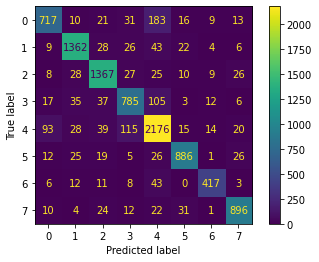

              precision    recall  f1-score   support

           0    0.82225   0.71700   0.76603      1000
           1    0.90559   0.90800   0.90679      1500
           2    0.88422   0.91133   0.89757      1500
           3    0.77800   0.78500   0.78148      1000
           4    0.82958   0.87040   0.84950      2500
           5    0.90132   0.88600   0.89360      1000
           6    0.89293   0.83400   0.86246       500
           7    0.89960   0.89600   0.89780      1000

    accuracy                        0.86060     10000
   macro avg    0.86419   0.85097   0.85690     10000
weighted avg    0.86063   0.86060   0.86004     10000


  • MEDIUM LEVEL 


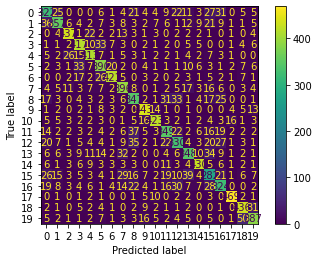

              precision    recall  f1-score   support

           0    0.65580   0.64400   0.64985       500
           1    0.79333   0.71400   0.75158       500
           2    0.86706   0.87400   0.87052       500
           3    0.77654   0.83400   0.80424       500
           4    0.80980   0.82600   0.81782       500
           5    0.73171   0.78000   0.75508       500
           6    0.88075   0.84200   0.86094       500
           7    0.73198   0.79200   0.76081       500
           8    0.67906   0.69400   0.68645       500
           9    0.84221   0.88600   0.86355       500
          10    0.87578   0.84600   0.86063       500
          11    0.72557   0.69800   0.71152       500
          12    0.69182   0.66000   0.67554       500
          13    0.72500   0.69600   0.71020       500
          14    0.86519   0.86000   0.86259       500
          15    0.57085   0.56400   0.56740       500
          16    0.66530   0.64800   0.65653       500
          17    0.93241   0

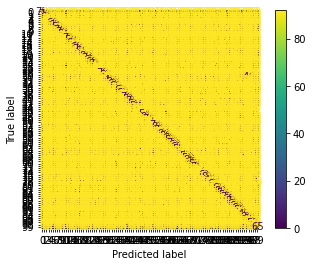

              precision    recall  f1-score   support

           0    0.83333   0.75000   0.78947       100
           1    0.86420   0.70000   0.77348       100
           2    0.35882   0.61000   0.45185       100
           3    0.49367   0.39000   0.43575       100
           4    0.28099   0.34000   0.30769       100
           5    0.50847   0.60000   0.55046       100
           6    0.70455   0.62000   0.65957       100
           7    0.57143   0.52000   0.54450       100
           8    0.85393   0.76000   0.80423       100
           9    0.90909   0.70000   0.79096       100
          10    0.37778   0.51000   0.43404       100
          11    0.30769   0.04000   0.07080       100
          12    0.58197   0.71000   0.63964       100
          13    0.50505   0.50000   0.50251       100
          14    0.35465   0.61000   0.44853       100
          15    0.51765   0.44000   0.47568       100
          16    0.47552   0.68000   0.55967       100
          17    0.82609   0

D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [22]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.7307616666666666 
Hierarchical Recall = 0.7445333333333333 
Hierarchical F1-Score = 0.7361599206349206 
Consistency =  0.9118 
Exact Match =  0.5495


# Training Again

In [23]:
model_save_dir = str(directory+'/trained_model_2.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    
    model.save_weights(model_save_dir)

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 0.1279 - prediction_coarse_accuracy: 0.9092 - prediction_medium_accuracy: 0.8657 - prediction_fine_accuracy: 0.5662
  • Coarse Accuracy = 90.92% | Val_Accuracy = 82.93% | LossWeight = 0.29 
  • Medium Accuracy = 86.57% | Val_Accuracy = 72.32% | LossWeight = 0.39 
  • Fine   Accuracy = 56.62% | Val_Accuracy = 49.01% | LossWeight = 0.32 

Epoch 1: val_prediction_fine_accuracy did not improve from 0.56320
781/781 [==============================] - 60s 77ms/step - loss: 0.1279 - prediction_coarse_accuracy: 0.9092 - prediction_medium_accuracy: 0.8657 - prediction_fine_accuracy: 0.5662 - val_loss: 0.1472 - val_prediction_coarse_accuracy: 0.8293 - val_prediction_medium_accuracy: 0.7232 - val_prediction_fine_accuracy: 0.4901 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.1376 - prediction_coarse_accuracy: 0.8940 - prediction_medium_accuracy: 0.8440 - prediction_fine_accuracy: 0.5463
  

781/781 [==============================] - 60s 77ms/step - loss: 0.1081 - prediction_coarse_accuracy: 0.9353 - prediction_medium_accuracy: 0.9090 - prediction_fine_accuracy: 0.6504 - val_loss: 0.1378 - val_prediction_coarse_accuracy: 0.8457 - val_prediction_medium_accuracy: 0.7460 - val_prediction_fine_accuracy: 0.5399 - lr: 0.0010
Epoch 11/100
781/781 [==============================] - ETA: 0s - loss: 0.1021 - prediction_coarse_accuracy: 0.9420 - prediction_medium_accuracy: 0.9173 - prediction_fine_accuracy: 0.6680
  • Coarse Accuracy = 94.20% | Val_Accuracy = 84.20% | LossWeight = 0.28 
  • Medium Accuracy = 91.73% | Val_Accuracy = 74.41% | LossWeight = 0.35 
  • Fine   Accuracy = 66.80% | Val_Accuracy = 54.49% | LossWeight = 0.37 

Epoch 11: val_prediction_fine_accuracy did not improve from 0.56320
781/781 [==============================] - 60s 77ms/step - loss: 0.1021 - prediction_coarse_accuracy: 0.9420 - prediction_medium_accuracy: 0.9173 - prediction_fine_accuracy: 0.6680 - val_

781/781 [==============================] - ETA: 0s - loss: 0.0939 - prediction_coarse_accuracy: 0.9500 - prediction_medium_accuracy: 0.9323 - prediction_fine_accuracy: 0.7314
  • Coarse Accuracy = 95.00% | Val_Accuracy = 84.49% | LossWeight = 0.29 
  • Medium Accuracy = 93.23% | Val_Accuracy = 75.31% | LossWeight = 0.35 
  • Fine   Accuracy = 73.14% | Val_Accuracy = 56.12% | LossWeight = 0.36 

Epoch 20: val_prediction_fine_accuracy did not improve from 0.56650
781/781 [==============================] - 60s 76ms/step - loss: 0.0939 - prediction_coarse_accuracy: 0.9500 - prediction_medium_accuracy: 0.9323 - prediction_fine_accuracy: 0.7314 - val_loss: 0.1305 - val_prediction_coarse_accuracy: 0.8449 - val_prediction_medium_accuracy: 0.7531 - val_prediction_fine_accuracy: 0.5612 - lr: 5.9874e-04
Epoch 21/100
781/781 [==============================] - ETA: 0s - loss: 0.0915 - prediction_coarse_accuracy: 0.9511 - prediction_medium_accuracy: 0.9348 - prediction_fine_accuracy: 0.7402
  • Coar

781/781 [==============================] - 59s 75ms/step - loss: 0.0868 - prediction_coarse_accuracy: 0.9550 - prediction_medium_accuracy: 0.9423 - prediction_fine_accuracy: 0.7836 - val_loss: 0.1263 - val_prediction_coarse_accuracy: 0.8560 - val_prediction_medium_accuracy: 0.7633 - val_prediction_fine_accuracy: 0.5873 - lr: 3.7735e-04
Epoch 30/100
781/781 [==============================] - ETA: 0s - loss: 0.0893 - prediction_coarse_accuracy: 0.9549 - prediction_medium_accuracy: 0.9388 - prediction_fine_accuracy: 0.7806
  • Coarse Accuracy = 95.49% | Val_Accuracy = 84.70% | LossWeight = 0.30 
  • Medium Accuracy = 93.88% | Val_Accuracy = 75.84% | LossWeight = 0.36 
  • Fine   Accuracy = 78.06% | Val_Accuracy = 58.06% | LossWeight = 0.34 

Epoch 30: val_prediction_fine_accuracy did not improve from 0.58730
781/781 [==============================] - 59s 75ms/step - loss: 0.0893 - prediction_coarse_accuracy: 0.9549 - prediction_medium_accuracy: 0.9388 - prediction_fine_accuracy: 0.7806 - 

Epoch 39/100
781/781 [==============================] - ETA: 0s - loss: 0.0841 - prediction_coarse_accuracy: 0.9589 - prediction_medium_accuracy: 0.9457 - prediction_fine_accuracy: 0.8209
  • Coarse Accuracy = 95.89% | Val_Accuracy = 84.95% | LossWeight = 0.31 
  • Medium Accuracy = 94.57% | Val_Accuracy = 75.91% | LossWeight = 0.37 
  • Fine   Accuracy = 82.09% | Val_Accuracy = 58.64% | LossWeight = 0.32 

Epoch 39: val_prediction_fine_accuracy did not improve from 0.59450
781/781 [==============================] - 60s 77ms/step - loss: 0.0841 - prediction_coarse_accuracy: 0.9589 - prediction_medium_accuracy: 0.9457 - prediction_fine_accuracy: 0.8209 - val_loss: 0.1294 - val_prediction_coarse_accuracy: 0.8495 - val_prediction_medium_accuracy: 0.7591 - val_prediction_fine_accuracy: 0.5864 - lr: 2.2594e-04
Epoch 40/100
781/781 [==============================] - ETA: 0s - loss: 0.0842 - prediction_coarse_accuracy: 0.9587 - prediction_medium_accuracy: 0.9463 - prediction_fine_accuracy: 0.

781/781 [==============================] - 61s 78ms/step - loss: 0.0832 - prediction_coarse_accuracy: 0.9598 - prediction_medium_accuracy: 0.9496 - prediction_fine_accuracy: 0.8424 - val_loss: 0.1249 - val_prediction_coarse_accuracy: 0.8589 - val_prediction_medium_accuracy: 0.7733 - val_prediction_fine_accuracy: 0.6032 - lr: 1.4240e-04
Epoch 49/100
781/781 [==============================] - ETA: 0s - loss: 0.0828 - prediction_coarse_accuracy: 0.9598 - prediction_medium_accuracy: 0.9478 - prediction_fine_accuracy: 0.8448
  • Coarse Accuracy = 95.98% | Val_Accuracy = 86.13% | LossWeight = 0.33 
  • Medium Accuracy = 94.78% | Val_Accuracy = 77.03% | LossWeight = 0.38 
  • Fine   Accuracy = 84.48% | Val_Accuracy = 60.16% | LossWeight = 0.29 

Epoch 49: val_prediction_fine_accuracy did not improve from 0.60650
781/781 [==============================] - 61s 78ms/step - loss: 0.0828 - prediction_coarse_accuracy: 0.9598 - prediction_medium_accuracy: 0.9478 - prediction_fine_accuracy: 0.8448 - 

781/781 [==============================] - ETA: 0s - loss: 0.0825 - prediction_coarse_accuracy: 0.9606 - prediction_medium_accuracy: 0.9502 - prediction_fine_accuracy: 0.8566
  • Coarse Accuracy = 96.06% | Val_Accuracy = 85.83% | LossWeight = 0.33 
  • Medium Accuracy = 95.02% | Val_Accuracy = 77.00% | LossWeight = 0.38 
  • Fine   Accuracy = 85.66% | Val_Accuracy = 60.22% | LossWeight = 0.28 

Epoch 58: val_prediction_fine_accuracy did not improve from 0.60650
781/781 [==============================] - 61s 78ms/step - loss: 0.0825 - prediction_coarse_accuracy: 0.9606 - prediction_medium_accuracy: 0.9502 - prediction_fine_accuracy: 0.8566 - val_loss: 0.1258 - val_prediction_coarse_accuracy: 0.8583 - val_prediction_medium_accuracy: 0.7700 - val_prediction_fine_accuracy: 0.6022 - lr: 8.5258e-05
Epoch 59/100
781/781 [==============================] - ETA: 0s - loss: 0.0830 - prediction_coarse_accuracy: 0.9594 - prediction_medium_accuracy: 0.9479 - prediction_fine_accuracy: 0.8537
  • Coar

781/781 [==============================] - 61s 78ms/step - loss: 0.0819 - prediction_coarse_accuracy: 0.9596 - prediction_medium_accuracy: 0.9498 - prediction_fine_accuracy: 0.8625 - val_loss: 0.1245 - val_prediction_coarse_accuracy: 0.8613 - val_prediction_medium_accuracy: 0.7726 - val_prediction_fine_accuracy: 0.6081 - lr: 5.3734e-05
Epoch 68/100
781/781 [==============================] - ETA: 0s - loss: 0.0822 - prediction_coarse_accuracy: 0.9612 - prediction_medium_accuracy: 0.9508 - prediction_fine_accuracy: 0.8663
  • Coarse Accuracy = 96.12% | Val_Accuracy = 86.12% | LossWeight = 0.34 
  • Medium Accuracy = 95.08% | Val_Accuracy = 77.43% | LossWeight = 0.39 
  • Fine   Accuracy = 86.63% | Val_Accuracy = 60.83% | LossWeight = 0.27 

Epoch 68: val_prediction_fine_accuracy did not improve from 0.60920
781/781 [==============================] - 61s 78ms/step - loss: 0.0822 - prediction_coarse_accuracy: 0.9612 - prediction_medium_accuracy: 0.9508 - prediction_fine_accuracy: 0.8663 - 

781/781 [==============================] - ETA: 0s - loss: 0.0813 - prediction_coarse_accuracy: 0.9615 - prediction_medium_accuracy: 0.9513 - prediction_fine_accuracy: 0.8699
  • Coarse Accuracy = 96.15% | Val_Accuracy = 86.26% | LossWeight = 0.34 
  • Medium Accuracy = 95.13% | Val_Accuracy = 77.36% | LossWeight = 0.39 
  • Fine   Accuracy = 86.99% | Val_Accuracy = 60.87% | LossWeight = 0.27 

Epoch 77: val_prediction_fine_accuracy did not improve from 0.60930
781/781 [==============================] - 61s 78ms/step - loss: 0.0813 - prediction_coarse_accuracy: 0.9615 - prediction_medium_accuracy: 0.9513 - prediction_fine_accuracy: 0.8699 - val_loss: 0.1239 - val_prediction_coarse_accuracy: 0.8626 - val_prediction_medium_accuracy: 0.7736 - val_prediction_fine_accuracy: 0.6087 - lr: 3.2172e-05
Epoch 78/100
781/781 [==============================] - ETA: 0s - loss: 0.0813 - prediction_coarse_accuracy: 0.9610 - prediction_medium_accuracy: 0.9514 - prediction_fine_accuracy: 0.8715
  • Coar

781/781 [==============================] - 60s 77ms/step - loss: 0.0812 - prediction_coarse_accuracy: 0.9611 - prediction_medium_accuracy: 0.9515 - prediction_fine_accuracy: 0.8712 - val_loss: 0.1242 - val_prediction_coarse_accuracy: 0.8616 - val_prediction_medium_accuracy: 0.7737 - val_prediction_fine_accuracy: 0.6095 - lr: 2.0277e-05
Epoch 87/100
781/781 [==============================] - ETA: 0s - loss: 0.0815 - prediction_coarse_accuracy: 0.9618 - prediction_medium_accuracy: 0.9520 - prediction_fine_accuracy: 0.8730
  • Coarse Accuracy = 96.18% | Val_Accuracy = 86.19% | LossWeight = 0.34 
  • Medium Accuracy = 95.20% | Val_Accuracy = 77.53% | LossWeight = 0.39 
  • Fine   Accuracy = 87.30% | Val_Accuracy = 60.91% | LossWeight = 0.27 

Epoch 87: val_prediction_fine_accuracy did not improve from 0.61060
781/781 [==============================] - 61s 78ms/step - loss: 0.0815 - prediction_coarse_accuracy: 0.9618 - prediction_medium_accuracy: 0.9520 - prediction_fine_accuracy: 0.8730 - 

Epoch 96/100
781/781 [==============================] - ETA: 0s - loss: 0.0818 - prediction_coarse_accuracy: 0.9618 - prediction_medium_accuracy: 0.9518 - prediction_fine_accuracy: 0.8730
  • Coarse Accuracy = 96.18% | Val_Accuracy = 86.16% | LossWeight = 0.34 
  • Medium Accuracy = 95.18% | Val_Accuracy = 77.44% | LossWeight = 0.39 
  • Fine   Accuracy = 87.30% | Val_Accuracy = 61.14% | LossWeight = 0.27 

Epoch 96: val_prediction_fine_accuracy did not improve from 0.61230
781/781 [==============================] - 61s 78ms/step - loss: 0.0818 - prediction_coarse_accuracy: 0.9618 - prediction_medium_accuracy: 0.9518 - prediction_fine_accuracy: 0.8730 - val_loss: 0.1249 - val_prediction_coarse_accuracy: 0.8616 - val_prediction_medium_accuracy: 0.7744 - val_prediction_fine_accuracy: 0.6114 - lr: 1.2140e-05
Epoch 97/100
781/781 [==============================] - ETA: 0s - loss: 0.0811 - prediction_coarse_accuracy: 0.9617 - prediction_medium_accuracy: 0.9527 - prediction_fine_accuracy: 0.

In [24]:
history_dict = history.history

(0.0, 1.0)

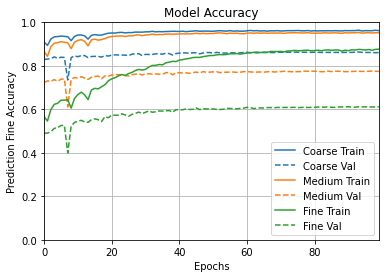

In [25]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
plt.title("Model Accuracy")
plt.ylim([0,1])

(0.0, 1.0)

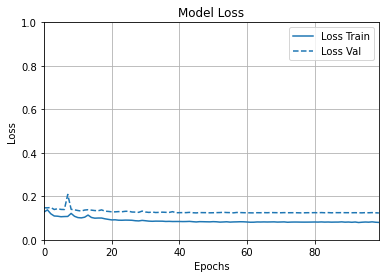

In [26]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"loss": history}, metric = "loss")
plt.title("Model Loss")
plt.ylim([0,1])

## Model Analysis

In [27]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 8s 19ms/step - loss: 0.1848 - prediction_coarse_loss: 0.1034 - prediction_medium_loss: 0.1705 - prediction_fine_loss: 0.3138 - prediction_coarse_accuracy: 0.8615 - prediction_medium_accuracy: 0.7745 - prediction_fine_accuracy: 0.6118
1. loss ==> 0.18478652834892273
2. prediction_coarse_loss ==> 0.1034010648727417
3. prediction_medium_loss ==> 0.17053067684173584
4. prediction_fine_loss ==> 0.3137598931789398
5. prediction_coarse_accuracy ==> 0.8615000247955322
6. prediction_medium_accuracy ==> 0.7745000123977661
7. prediction_fine_accuracy ==> 0.6118000149726868
313/313 [==============================] - 5s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

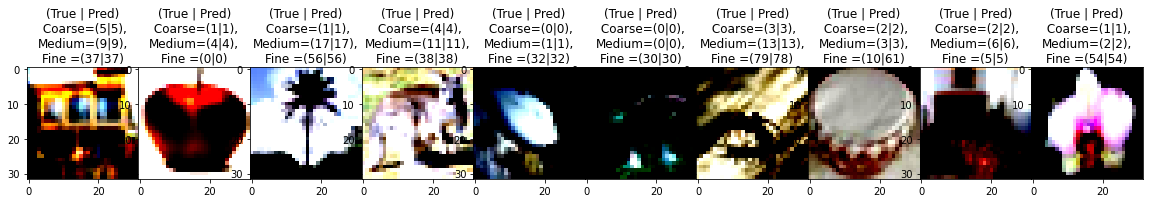

In [28]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[ 697   13   20   27  211   10   13    9]
 [   4 1365   25   33   40   22    4    7]
 [   9   29 1372   25   23   13    9   20]
 [  15   34   30  771  119    2   12   17]
 [  91   20   36   89 2219   12   14   19]
 [   9   24   24    4   31  878    1   29]
 [   4   13   14    8   38    1  420    2]
 [   5    4   31   11   22   33    1  893]]

  • MEDIUM LEVEL 
[[312  22   0   2   0   4   0   4  30   1   4   9  23  10   5  38  29   0
    2   5]
 [ 34 354   4   5  10   7   0   6   4   3   6   3   7   6  13  27   6   0
    2   3]
 [  0   2 441   3  20   2   1  13   1   2   1   1   1   3   3   1   1   1
    0   3]
 [  2   1   3 399  11  47   6   3   0   3   1   2   1   9   4   1   0   0
    1   6]
 [  3   1  20   8 418   9   1   5   5   1   2   4   2   9   2   3   7   0
    0   0]
 [  1   3   0  28   6 401  16   3   2   5   1   0   1  11   7   2   1   1
    3   8]
 [  0   0   3  16   2  28 435   2   0   2   1   0   0   0   1   0   2   1
    5   2]


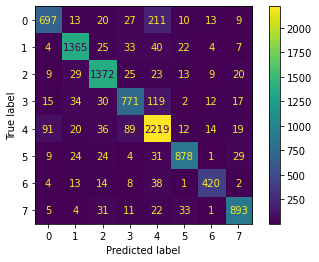

              precision    recall  f1-score   support

           0    0.83573   0.69700   0.76009      1000
           1    0.90879   0.91000   0.90939      1500
           2    0.88402   0.91467   0.89908      1500
           3    0.79649   0.77100   0.78354      1000
           4    0.82094   0.88760   0.85297      2500
           5    0.90422   0.87800   0.89092      1000
           6    0.88608   0.84000   0.86242       500
           7    0.89659   0.89300   0.89479      1000

    accuracy                        0.86150     10000
   macro avg    0.86661   0.84891   0.85665     10000
weighted avg    0.86176   0.86150   0.86057     10000


  • MEDIUM LEVEL 


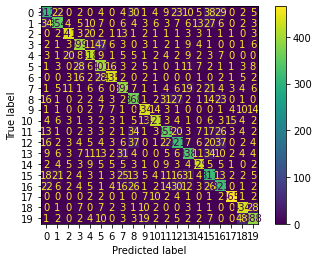

              precision    recall  f1-score   support

           0    0.68571   0.62400   0.65340       500
           1    0.80638   0.70800   0.75399       500
           2    0.88200   0.88200   0.88200       500
           3    0.80120   0.79800   0.79960       500
           4    0.80077   0.83600   0.81800       500
           5    0.71226   0.80200   0.75447       500
           6    0.88235   0.87000   0.87613       500
           7    0.74952   0.78400   0.76637       500
           8    0.67772   0.73600   0.70566       500
           9    0.85098   0.86800   0.85941       500
          10    0.88075   0.84200   0.86094       500
          11    0.73958   0.71000   0.72449       500
          12    0.67155   0.64200   0.65644       500
          13    0.71762   0.67600   0.69619       500
          14    0.85629   0.85800   0.85714       500
          15    0.58595   0.63400   0.60903       500
          16    0.65517   0.64600   0.65055       500
          17    0.93373   0

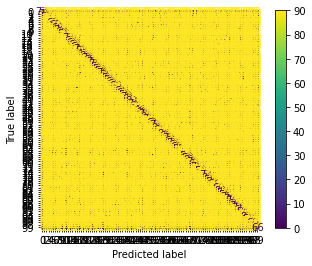

              precision    recall  f1-score   support

           0    0.87500   0.77000   0.81915       100
           1    0.87654   0.71000   0.78453       100
           2    0.44167   0.53000   0.48182       100
           3    0.42169   0.35000   0.38251       100
           4    0.47222   0.34000   0.39535       100
           5    0.65686   0.67000   0.66337       100
           6    0.75904   0.63000   0.68852       100
           7    0.51128   0.68000   0.58369       100
           8    0.79167   0.76000   0.77551       100
           9    0.85000   0.68000   0.75556       100
          10    0.39259   0.53000   0.45106       100
          11    0.42105   0.32000   0.36364       100
          12    0.64167   0.77000   0.70000       100
          13    0.53846   0.63000   0.58065       100
          14    0.48062   0.62000   0.54148       100
          15    0.57759   0.67000   0.62037       100
          16    0.54545   0.66000   0.59729       100
          17    0.85057   0

In [29]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [30]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.7474799999999999 
Hierarchical Recall = 0.7625 
Hierarchical F1-Score = 0.753311111111111 
Consistency =  0.9068 
Exact Match =  0.5952
